In [ ]:
import os
from dotenv import load_dotenv

# Change to the 10_Modal directory
os.chdir("10_Modal")

os.environ["PYTHONIOENCODING"] = "utf-8"

load_dotenv(override=True)

In [2]:
from openai import OpenAI

openai = OpenAI()

In [4]:
import pickle

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [6]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [7]:
import chromadb

DB = "products_vectorstore"

client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [8]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [9]:
description(test[0])

'Dale Tiffany Poelking Blue Lily Table Lamp, 12 x 12 x 22.75\nOur Poleking series of table lamps is an easy way to add unique color and charm to any room of your home. This 2 light lily lamp features two elegant lily blossoms in shimmery pink art glass. Each of the 5 panels on each shade feature fluid, graceful edges that faithfully recreate 2 delicate lily blossoms. The shades hang from 2 gracefully curved stems flowing from an intricately carved metal base, which is finished dark antique bronze. A perfect choice for a boudoir or powder room, this charming lamp is will provide your family with years of beautiful, reliable lighting. Dual Light Lily Lamp featuring two elegant lilies in shimmery blue'

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [11]:
def vector(item):
    return model.encode([description(item)])

In [12]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [13]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

MIGHTY SKINS MightySkins Glossy Glitter Skin for Beats Pill Plus - Mexican Flag | Protective, Durable High-Gloss Glitter Finish | Easy to Apply, Remove, and Change Styles | Made in The USA
Introducing Glitter Skins With Printed HD Designs Only From MightySkins We are proud to introduce our new Glitter Skin line which features a full HD printed design with a unique glossy glitter finish. Do You Want Your Beats Pill Plus To Look Different Than The Rest? You’re in the right place because we’ve got exactly what you’re looking for! This skin is the perfect way to show off your style! Or with hundreds of other MightySkins designs, you can be sure to find one that you’ll love, and that will show off your unique style

Price is $15.00


In [15]:
documents, prices = find_similars(test[1])
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
MIGHTY SKINS MightySkins Carbon Fiber Skin for Microsoft Surface Duo - Geo Sugar Skull | Protective, Durable Textured Carbon Fiber Finish | Easy to Apply | Made in The USA
Introducing Textured Carbon Fiber Skins With Printed Hd Designs Only From Mightyskins we are proud to introduce the new textured carbon fiber skin line which feature a full HD printed design with a textured carbon fiber finish. Do You Want Your Microsoft Surface Duo To Look Different Than The Rest? You’re in the right place because we’ve got exactly what you’re looking for! This Geo Sugar Skull skin is the perfect way to show off your style! Or with hundreds of other MightySkins designs, you can be sure to find one that you’ll love, and that will show off your unique style! Do
Price is $18.54

Potentially related product:
MightySkins Skin for Beats Solo Pro Wireless Headphones - Rai

In [17]:
messages_for(test[1], documents, prices)

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nMIGHTY SKINS MightySkins Carbon Fiber Skin for Microsoft Surface Duo - Geo Sugar Skull | Protective, Durable Textured Carbon Fiber Finish | Easy to Apply | Made in The USA\nIntroducing Textured Carbon Fiber Skins With Printed Hd Designs Only From Mightyskins we are proud to introduce the new textured carbon fiber skin line which feature a full HD printed design with a textured carbon fiber finish. Do You Want Your Microsoft Surface Duo To Look Different Than The Rest? You’re in the right place because we’ve got exactly what you’re looking for! This Geo Sugar Skull skin is the perfect way to show off your style! Or with hundreds of other MightySkins designs, you can be sure to find one that you’ll love, and tha

In [19]:
import re

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [20]:
get_price("The price for this is $99.99")

99.99

In [21]:
def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [22]:
gpt_4o_mini_rag(test[1])

15.99

In [23]:
test[1].price

14.99

1: Guess: $249.99 Truth: $155.00 Error: $94.99 SLE: 0.23 Item: Dale Tiffany TT12147 Poelking 2-Light Bl...
2: Guess: $19.99 Truth: $14.99 Error: $5.00 SLE: 0.07 Item: MIGHTY SKINS MightySkins Glossy Glitter ...
3: Guess: $15.99 Truth: $21.99 Error: $6.00 SLE: 0.09 Item: Goodsprout Compatible with Samsung Galax...
4: Guess: $54.67 Truth: $51.55 Error: $3.12 SLE: 0.00 Item: 880LMW Smart Control Panel ONLY Compatib...
5: Guess: $10.99 Truth: $9.99 Error: $1.00 SLE: 0.01 Item: Cobweb Bulletin Board Borders for Hallow...
6: Guess: $35.24 Truth: $27.50 Error: $7.74 SLE: 0.06 Item: Detroit Axle - Front Ceramic Brake Pads ...
7: Guess: $149.99 Truth: $87.56 Error: $62.43 SLE: 0.28 Item: ACDelco Professional 18FR1383C Rear Pass...
8: Guess: $14.99 Truth: $9.99 Error: $5.00 SLE: 0.14 Item: Noare Educational Math Posters for Kids ...
9: Guess: $119.99 Truth: $169.00 Error: $49.01 SLE: 0.12 Item: Ryobi 10 in. 40-Volt Cordless Pole Saw (...
10: Guess: $299.99 Truth: $449.00 Error: $149.01 SLE: 0.16

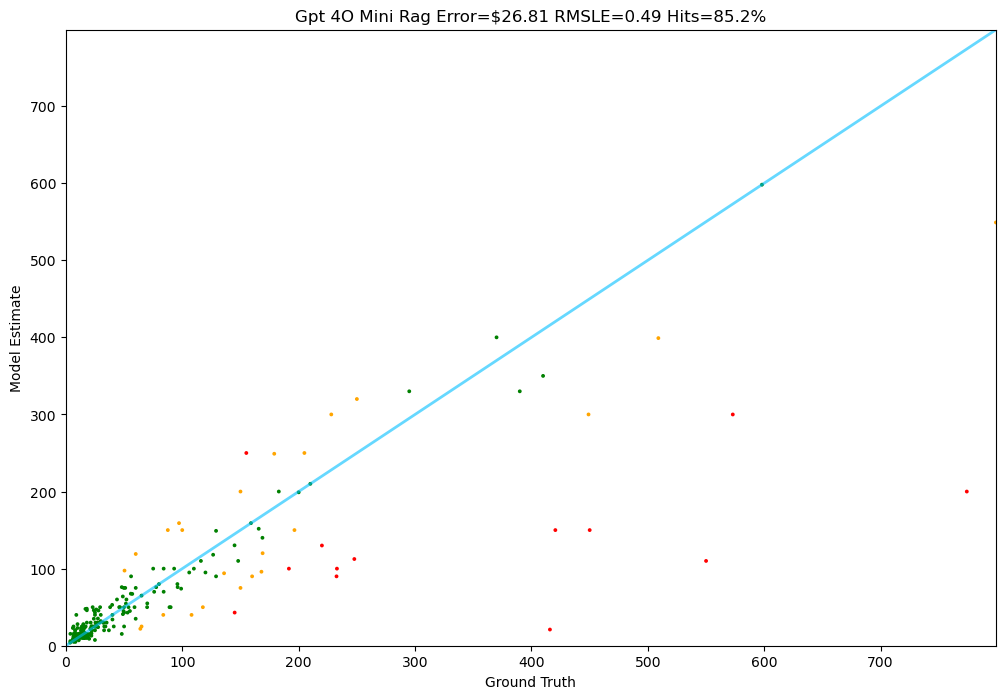

In [24]:
from tester import Tester

Tester.test(gpt_4o_mini_rag, test)